<a href="https://colab.research.google.com/github/surkovvv/loan_default_prediction/blob/nick/LoanDefaultPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузим все необходимые библиотеки

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

In [62]:
X = pd.read_csv("applicationdata.csv")
#df1.sample(10)
#pd.options.display.max_columns = None
X.sample(5)

,CustomerID,LoanType,Reason,Application.Date,Employment.Length,Employment.Sector,RequestedAmount,OfferedAmount,FundedAmount,Duration,Age,EmailDomain,Residential.Status,Sex,Marital.Status,Dependents,City,State,PostalCode,Pay.Frequency,Product,Risk.Rating,Employment.Type,Requested.Duration,ArrearsLevel,IsWrittenOff,age.of.file,age.of.subject,time.at.address,time.at.employer,defaults,total.value.of.outstanding.defaults,defaults.paid,defaults.12,time.since.last.default,credit.enquiries.1,credit.enquiries.3,credit.enquiries.6,credit.enquiries.12,credit.enquiries.60,...,OverdrawnFees_wages_ratio,UncategorisedDebits_wages_ratio,OtherDebits_wages_ratio,AllOtherCredits_wages_ratio,Utilities_wages_ratio,AtmWithdrawals_wages_ratio,Gambling_wages_ratio,Groceries_wages_ratio,Insurance_wages_ratio,SubscriptionTv_wages_ratio,Telecommunications_wages_ratio,Transport_wages_ratio,Wages_repaymentcapacity_ratio,Centrelink_repaymentcapacity_ratio,SaccLoans_repaymentcapacity_ratio,NonSaccLoans_repaymentcapacity_ratio,DebtConsolidation_repaymentcapacity_ratio,DebtCollection_repaymentcapacity_ratio,Rent1_repaymentcapacity_ratio,OverdrawnFees_repaymentcapacity_ratio,UncategorisedDebits_repaymentcapacity_ratio,OtherDebits_repaymentcapacity_ratio,AllOtherCredits_repaymentcapacity_ratio,Utilities_repaymentcapacity_ratio,AtmWithdrawals_repaymentcapacity_ratio,Gambling_repaymentcapacity_ratio,Groceries_repaymentcapacity_ratio,Insurance_repaymentcapacity_ratio,SubscriptionTv_repaymentcapacity_ratio,Telecommunications_repaymentcapacity_ratio,Transport_repaymentcapacity_ratio,Income_MonthlyRepayments_ratio,NonDiscretionarySpending_MonthlyRepayments_ratio,DiscretionarySpending_MonthlyRepayments_ratio,RepaymentCapacity_MonthlyRepayments_ratio,MaxCdia,Isdefault,Isapproved,Inrange,Hasjson
929,188659.0,New,"Rent or rental bond,Home appliances or furniture",2016-12-20 15:09:48.833,More than 1 year,Customer Service & Call Center,2400.0,2400.0,2400.0,6 months,24.0,hotmail.com,Rent,F,Single,0,Seven Hills,New South Wales,2147.0,Weekly,MACC,A4,Full time,6 months,NaN,0.0,70.00,24.00,54.00,16.0,0.0,0.0,0.0,0.0,NaN,1.0,2.0,2.0,2.0,11.0,...,0.0120,0.0000,0.0000,1.6148,0.0000,0.0209,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.2254,0.0000,0.0,0.1183,0.0,0.0,0.5044,0.0268,0.0000,0.0000,3.5937,0.0000,0.0466,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.9668,2.5252,0.7604,2.6811,0.0,0.0,1.0,1.0,1.0
2166,187411.0,New,"Bank loans (e.g. mortgage, personal loan and c...",2016-12-17 11:31:06.423,More than 1 year,"Construction, Building & Architecture",7000.0,3500.0,3500.0,24 months,24.0,hotmail.com,Rent,M,Defacto,0,Blacktown,New South Wales,2148.0,Weekly,MACC,A4,Full time,36 months,M0,0.0,69.00,24.00,2.00,11.0,0.0,0.0,0.0,0.0,NaN,1.0,2.0,2.0,3.0,4.0,...,0.0015,0.0000,0.1759,0.5173,0.0000,0.0406,0.0301,0.0000,0.0000,0.0000,0.0000,0.0000,1.7866,0.0000,0.0,0.0000,0.0,0.0,0.5459,0.0028,0.0000,0.3142,0.9243,0.0000,0.0726,0.0537,0.0000,0.0000,0.0000,0.0000,0.0000,10.8055,3.9929,0.7645,6.0481,6.0,0.0,1.0,1.0,1.0
9742,287603.0,New,Child & dependent related expenses,2017-11-23 08:12:16.623,More than 1 year,Education and Training,4000.0,2500.0,2500.0,9 months,24.0,outlook.com,Rent,F,Defacto,2,Gilmore,Australian Capital Territory,2905.0,Fortnightly,MACC,A5,Part time,24 months,M1,0.0,57.92,288.01,2.00,0.0,0.0,NaN,0.0,0.0,NaN,2.0,3.0,4.0,5.0,9.0,...,0.0000,0.1851,0.2696,1.1036,0.0000,0.0379,0.0026,0.0506,0.0247,0.0309,0.0940,0.0000,5.2041,0.0357,0.0,1.0731,0.0,0.0,1.9854,0.0002,0.9703,1.4130,5.7828,0.0000,0.1986,0.0136,0.2653,0.1296,0.1620,0.4927,0.0000,11.8551,6.7370,2.8555,2.2624,18.0,0.0,1.0,1.0,1.0
12741,263554.0,New,Purchase,2017-08-26 19:34:27.830,More than 1 year,Education and Training,6000.0,6000.0,6000.0,12 months,52.0,icloud.com,Rent,F,Married,0,Templestowe Lower,Victoria,3107.0,Fortnightly,PL,A1,Full time,12 months,NaN,0.0,390.25,627.01,22.15,0.0,0.0,NaN,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.4866,0.1398,2.6636,0.0649,0.0354,0.0056,0.2947,0.0827,0.0000,0.0157,0.0009,8.5358,0.1579,0

# Отступ ⬇

# Отспуп ⬆

In [63]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12982 entries, 0 to 12981
Columns: 216 entries, CustomerID to Hasjson
dtypes: float64(194), object(22)
memory usage: 21.4+ MB


In [64]:
features = X.columns.values
features.shape[0]

216

Видно, что признаков очень много, но возникает ощущение, что далеко не все из них полезны

In [65]:
X = X.drop(index=X[X.isna().sum(axis=1) >= 100].index)

In [66]:
#X = df1.drop("Isdefault", axis=1)
#y = df1["Isdefault"]

In [67]:
#y = y.iloc[:-2].astype(int)
X = X.iloc[:-2, :]

In [68]:
print("Столбец количество пропусков количество уникальных значений")
for col in X:
    print(col, X[col].isna().sum(), X[col].nunique())

Столбец количество пропусков количество уникальных значений
CustomerID 0 12279
LoanType 0 2
Reason 0 894
Application.Date 0 12957
Employment.Length 47 3
Employment.Sector 57 26
RequestedAmount 0 95
OfferedAmount 0 86
FundedAmount 0 87
Duration 0 34
Age 0 48
EmailDomain 0 555
Residential.Status 7 3
Sex 0 2
Marital.Status 136 3
Dependents 136 4
City 2 4177
State 0 9
PostalCode 0 1569
Pay.Frequency 0 3
Product 0 2
Risk.Rating 0 7
Employment.Type 0 5
Requested.Duration 0 39
ArrearsLevel 5889 4
IsWrittenOff 0 2
age.of.file 150 2686
age.of.subject 150 2614
time.at.address 150 1756
time.at.employer 1106 908
defaults 150 3
total.value.of.outstanding.defaults 2971 259
defaults.paid 150 3
defaults.12 150 3
time.since.last.default 12348 128
credit.enquiries.1 150 9
credit.enquiries.3 150 17
credit.enquiries.6 150 21
credit.enquiries.12 150 28
credit.enquiries.60 150 50
time.since.last.enquiry 673 902
telco.and.utility.defaults 150 3
telco.and.utility.defaults.12 150 3
telco.and.utility.enquiries 

#### ***Видно***, что всякие признаки, названия которых оканчиваются на num, CC, PL, Tran и ratio имеют непривлекательно много пропусков, к тому же, для CC, PL, Tran префиксы совпадают для признаков, оканчивающихся на All, так что возможно, что это по сути одно и то же, просто с разных сторон. Для All очень мало пропусков, так что сначала мы и возьмем в нашу модель

In [69]:
bad_features = []
for col_name in X.columns:
    if (col_name.endswith("num") or col_name.endswith("_CC") or col_name.endswith("_PL") or 
        col_name.endswith("_Tran") or col_name.endswith("_ratio")):
        bad_features.append(col_name)
X.drop(columns=bad_features, inplace=True)

## Мое предположение, что от адреса электронной почты, postal code и applycationDate таргет слабо зависит, можно их дропнуть(сделаем из даты 2 новых столбца - год и месяц), а так же удалим признаки, способствующих переобучению (по заявлению автора статьи) IsWrittenOff, MaxCdia, а так же последние три признака - у них всего 1 уникальное значение, это ни о чем не скажет нашей модели

## Второе замечание - уникальных ID всего 12300, надо с ними разобраться..

In [70]:
X['Year'] = X['Application.Date'].apply(lambda x : int(x[:4]))
X['Month'] = X['Application.Date'].apply(lambda x : int(x[5:7]))
X.drop("Application.Date", axis=1, inplace=True)

In [71]:
X.drop(columns=["PostalCode", "contributing.factors", "TDatePart","time.since.last.default", 
                "IsWrittenOff", "MaxCdia", "Isapproved", "Inrange", "Hasjson"], inplace=True)

Теперь нам предстоит работа с пропусками - попробуем по максимуму разобраться и адекватно заполнить пропуски - потому что тут есть столбцы с вполне понятными заменами для NaN 

In [72]:
# этот код показывает, сколько будет пропусков в каждом столбце (числовом), если в нем убрать строки с NaN'овыми age.of.file
# аналогично можно поступить с окончанием ratio и All 
# в итоге, мы потеряем около 1100 строк (для ratio можно просто удалить все эти столбцы..)

# это основано на том, что эти столбцы идут пачками, если в строке NaN в age.of.file, то в этой же строке NaN и в age.of.subject, и в других соседних
bad_cols = []
for col in X.select_dtypes(include='number').columns.values:
    number_of_nans = X.loc[X[X["age.of.file"].notna()].index][col].isna().sum()
    if number_of_nans > 0:
        bad_cols.append((col, number_of_nans))
 

In [73]:
# Посмотрим, что за столбцы, и сколько в них пропусков:
bad_cols

[('time.at.employer', 956),
 ('total.value.of.outstanding.defaults', 2821),
 ('time.since.last.enquiry', 523),
 ('Subscription_TV', 9735),
 ('currentBalance_All', 1),
 ('availableBalance_All', 1),
 ('openingBalance_All', 1),
 ('totalCredits_All', 1),
 ('totalDebits_All', 1),
 ('closingBalance_All', 1),
 ('daysInNegative_All', 1),
 ('totalTX_All', 5),
 ('totalCR_All', 5),
 ('totalDR_All', 5),
 ('totalCRvalue_All', 5),
 ('totalDRvalue_All', 5),
 ('maxCRvalue_All', 5),
 ('minCRvalue_All', 5),
 ('maxDRvalue_All', 5),
 ('minDRvalue_All', 5),
 ('minBalance_All', 5),
 ('maxBalance_All', 5)]

In [74]:
# удалим каскадно те самые 5 строчек, где проблема у стоблцов, оканчивающихся на _All, 
# все остальные заполним нулями
X.drop(index=X[X["age.of.file"].isna()].index, inplace=True)
#y.drop(index=X[X["age.of.file"].isna()].index, inplace=True)
X.drop(index=X[X["totalCR_All"].isna()].index, inplace=True)
#y.drop(index=X[X["totalCR_All"].isna()].index, inplace=True)

Прогоним еще раз, чтобы получить столбцы, которые мы заполним нулями:

In [75]:
bad_cols_2 = []
for col in X.select_dtypes(include='number').columns.values:
    number_of_nans = X[col].isna().sum()
    if number_of_nans > 0:
        bad_cols_2.append(col)
for col_name in bad_cols_2:
    X[col_name].fillna(0, inplace=True)

Готово, теперь разберемся с категориальными данными:

In [76]:
import re

def func(List, data):
  data = str(data)
  data = re.sub(r'\s*\([^()]*\)\s*', '', data)
  data = data.split(",")
  for item in data:
    for reason in List:
      if item == reason:
        return item
  return "other"     

Set = set()
Dict = dict()
for data in X["Reason"]:
  data = str(data)
  data = re.sub(r'\s*\([^()]*\)\s*', '', data)
  data = data.split(",")
  for item in data:
    if item in Set:
      Dict[item] += 1
    else:
      Set.add(item)
      Dict[item] = 1
sorted_dict = {}
sorted_keys = sorted(Dict, key=Dict.get)  
List = list()
for i in range(20):
  List.append(sorted_keys.pop())
X["Reason"] = X["Reason"].apply(lambda x: func(List, x))

In [77]:
def func(List, data):
  data = str(data)
  for item in List:
    if data == item:
      return data
  return "other"

Set = set()
Dict = dict()
for data in X["City"]:
  data = str(data)
  if data in Set:
    Dict[data] += 1
  else:
    Set.add(data)
    Dict[data] = 1
sorted_keys = sorted(Dict, key=Dict.get) 
List = list()
for i in range(20):
  List.append(sorted_keys.pop())
X["City"] = X["City"].apply(lambda x: func(List, x))


In [78]:

def func(List, data):
  data = str(data)
  for item in List:
    if data == item:
      return data
  return "other"

Set = set()
Dict = dict()
for data in X["EmailDomain"]:
  data = str(data)
  if data in Set:
    Dict[data] += 1
  else:
    Set.add(data)
    Dict[data] = 1
sorted_keys = sorted(Dict, key=Dict.get) 
List = list()
for i in range(20):
  List.append(sorted_keys.pop())
X["EmailDomain"] = X["EmailDomain"].apply(lambda x: func(List, x))


In [79]:
def func(data):
  if len(data)>2 and data[2] == '+':
    return int(data[1:2])
  else:
    return int(data[1:])
X["Risk.Rating"] = X["Risk.Rating"].apply(lambda x: func(x))

In [80]:
X["Duration"] = X["Duration"].apply(lambda x: int(x.split()[0]))
X["Requested.Duration"] = X["Requested.Duration"].apply(lambda x: int(x.split()[0]))


In [81]:
#print("Столбец количество пропусков количество уникальных значений после обработки")
#for col in X:
#    print(col, X[col].isna().sum(), X[col].nunique())
# Последний штрих:
to_fill = ["Employment.Length", "Employment.Sector", "Residential.Status"]
to_delete_indexes = ["Marital.Status", "Dependents"]
to_delete_col = "ArrearsLevel"

In [82]:
X[to_fill[0]].fillna("3 months to 1 year", inplace=True)
X[to_fill[0]].fillna("Construction, Building & Architecture", inplace=True)
X[to_fill[0]].fillna("Rent", inplace=True)

In [83]:
X.drop(index=X[X[to_delete_indexes[0]].isna()].index, inplace=True)
#y.drop(index=X[X[to_delete_indexes[0]].isna()].index, inplace=True)

In [84]:
X.drop(columns=[to_delete_col,"CustomerID"], inplace=True)

In [85]:
print("Столбец количество пропусков количество уникальных значений после обработки")
for col in X:
    print(col, X[col].isna().sum(), X[col].nunique())

Столбец количество пропусков количество уникальных значений после обработки
LoanType 0 2
Reason 0 20
Employment.Length 0 3
Employment.Sector 57 26
RequestedAmount 0 95
OfferedAmount 0 86
FundedAmount 0 87
Duration 0 34
Age 0 48
EmailDomain 0 21
Residential.Status 7 3
Sex 0 2
Marital.Status 0 3
Dependents 0 4
City 0 21
State 0 8
Pay.Frequency 0 3
Product 0 2
Risk.Rating 0 6
Employment.Type 0 5
Requested.Duration 0 35
age.of.file 0 2673
age.of.subject 0 2598
time.at.address 0 1748
time.at.employer 0 902
defaults 0 3
total.value.of.outstanding.defaults 0 257
defaults.paid 0 3
defaults.12 0 3
credit.enquiries.1 0 9
credit.enquiries.3 0 17
credit.enquiries.6 0 21
credit.enquiries.12 0 28
credit.enquiries.60 0 50
time.since.last.enquiry 0 894
telco.and.utility.defaults 0 3
telco.and.utility.defaults.12 0 3
telco.and.utility.enquiries 0 12
telco.and.utility.enquiries.6 0 5
telco.and.utility.enquiries.12 0 6
directorships.current 0 7
directorships.previous 0 8
adverse.on.file 0 4
applicant.odd

## Итоги: 

### Мы максимально почистили датасет, при чем нам пришлось срезать как немного признаков, так и немного объектов, но мы надеемся, что это не сильно скажется на обучении наших моделей.

In [ ]:
y = X["Isdefault"]
X = X.drop("Isdefault", axis=1)

In [86]:
X.head()

,LoanType,Reason,Employment.Length,Employment.Sector,RequestedAmount,OfferedAmount,FundedAmount,Duration,Age,EmailDomain,Residential.Status,Sex,Marital.Status,Dependents,City,State,Pay.Frequency,Product,Risk.Rating,Employment.Type,Requested.Duration,age.of.file,age.of.subject,time.at.address,time.at.employer,defaults,total.value.of.outstanding.defaults,defaults.paid,defaults.12,credit.enquiries.1,credit.enquiries.3,credit.enquiries.6,credit.enquiries.12,credit.enquiries.60,time.since.last.enquiry,telco.and.utility.defaults,telco.and.utility.defaults.12,telco.and.utility.enquiries,telco.and.utility.enquiries.6,telco.and.utility.enquiries.12,...,minDRvalue_All,minBalance_All,maxBalance_All,EntropyText,EntropyDate,Salary,Rent,LoanCommitments,LivingExpenses,Wages,Centrelink,SaccLoans,NonSaccLoans,DebtConsolidation,DebtCollection,Rent1,OverdrawnFees,UncategorisedDebits,OtherDebits,AllOtherCredits,Utilities,AtmWithdrawals,Gambling,Groceries,Insurance,SubscriptionTv,Telecommunications,Transport,OnGoingSaccCount,DishounorIn90Days,Income,NonDiscretionarySpending,DiscretionarySpending,RepaymentCapacity,RepaymentFromRequested,ExcessCapacity,RepaymentsRatio,Isdefault,Year,Month
0,New,other,More than 1 year,Customer Service & Call Center,2500.0,2500.0,2500.0,12,21.0,live.com.au,Rent,F,Married,0,other,New South Wales,Fortnightly,MACC,5,Full time,24,46.0,21.0,8.0,0.0,1.0,698.0,0.0,1.0,2.0,4.0,5.0,7.0,19.0,0.0,1.0,1.0,2.0,0.0,0.0,...,-1.00,1.00,1697.19,6.193471,2.405919,16801.0,700.0,836.0,500.0,-0.005,0.00,0.0000,30.2037,0.0,0.0,700.0,0.0,0.0000,312.2203,15.5462,0.000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,-0.005,1536.0000,500.0000,-2036.0050,161.71,-2197.715,0.0000,0.0,2016,11
1,Repeat,other,More than 1 year,Government & Defence,5500.0,3000.0,3000.0,24,26.0,hotmail.com,Rent,M,Married,2,other,Victoria,Fortnightly,MACC,3,Full time,24,82.0,25.0,20.0,20.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,12.0,7.0,0.0,0.0,0.0,0.0,0.0,...,-1.00,-916.77,6078.60,7.458622,2.252031,2200.0,1000.0,40.0,1000.0,3145.460,2170.89,790.1979,200.2498,0.0,0.0,1000.0,0.0,407.6374,527.9387,3994.2321,209.199,155.4629,0.0,573.8661,120.3012,188.1473,297.3398,6.3165,2.0,0.0,5316.350,1990.4477,1550.6332,1775.2690,303.80,1471.469,17.1128,0.0,2016,11
2,New,other,More than 1 year,"Logistics, Transport & Supply",6300.0,6300.0,6300.0,30,37.0,gmail.com,Rent,M,Married,0,other,New South Wales,Fortnightly,PL,4,Full time,36,243.0,37.0,29.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,4.0,19.0,2.0,0.0,0.0,2.0,0.0,0.0,...,-0.01,-36.20,2458.65,6.653219,2.646279,2526.0,340.0,325.0,370.0,0.000,0.00,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.000,0.0000,0.0000,0.0000,0.00,0.000,0.0000,0.0,2016,11
4,Repeat,other,3 months to 1 year,Other,4500.0,2500.0,2500.0,13,30.0,outlook.com,Living with friends,F,Married,1,other,Northern Territory,Fortnightly,MACC,5,Part time,13,17.0,30.0,17.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,4.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.01,-3.70,334.43,5.667073,1.543058,819.0,0.0,0.0,300.0,-0.005,238.14,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,437.6654,0.000,209.5370,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,238.135,0.0000,209.5370,28.5979,440.92,-412.322,0.0000,1.0,2016,11
5,New,other,More than 1 year,NaN,3500.0,3500.0,3500.0,18,49.0,hotmail.com,Own,F,Married,0,other,Queensland,Fortnightly,MACC,4,Part time,18,229.0,49.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,5.0,21.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-13.31,200.50,1430.42,4.713893,1.826245,1120.0,200.0,0.0,500.0,0.000,0.00,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.000,0.0000,0.0000,0.0000,0.00,0.000,0.0000,0.0,2016,11


In [ ]:
pip install lightgbm

In [ ]:
pip install catboost

In [ ]:
pip install xgboost

In [ ]:
pip install -U KTBoost

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import plot_roc_curve, classification_report, accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import xgboost as xgb
import KTBoost.KTBoost as KTBoost

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=66)
numeric_features = X.select_dtypes(include='number').columns
categorical_features = X.select_dtypes(include='object').columns

scaler = StandardScaler()
encoder = LabelEncoder()

ohe_cat_df = pd.get_dummies(X[categorical_features])
X.drop(columns=categorical_features, inplace=True)
#for column in categorical_features:
#    X[column] = encoder.fit_transform(X[column])
X[numeric_features] = scaler.fit_transform(X[numeric_features])
X = X.join(ohe_cat_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=66)

In [ ]:
X.shape

(12670, 212)

Accuracy on LogisticRegression= 0.8301767676767676


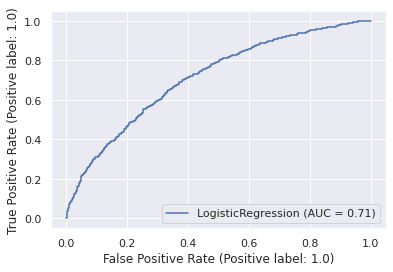

In [89]:
logres = LogisticRegression()

logres.fit(X_train, y_train)
y_pred1 = logres.predict(X_test)
print("Accuracy on LogisticRegression=", accuracy_score(y_test, y_pred1))
#print(classification_report(y_test, y_pred1))
plot_roc_curve(logres, X_test, y_test)

In [87]:
"""
model = KTBoost.BoostingClassifier(loss='deviance',base_learner='combined',
                                    update_step='newton',theta=1)
model.fit(X_train, y_train)
y_pred_grabit = model.predict(X_test)
print(classification_report(y_test, y_pred_grabit))
plot_roc_curve(model, X_test, y_test)
"""

TypeError: ignored

In [ ]:
"""
model = KTBoost.BoostingClassifier(loss='deviance',update_step='gradient')
model.fit(X_train, y_train)
y_pred_g = model.predict(X_test)
print(classification_report(y_test, y_pred_g))
plot_roc_curve(model, X_test, y_test)
"""

TypeError: ignored

Accuracy on AdaBoost Classifier= 0.8295454545454546


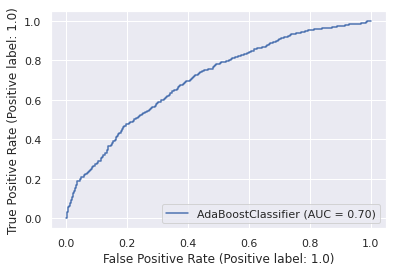

In [92]:
AdaBoost = AdaBoostClassifier(n_estimators=100, random_state=66)
AdaBoost.fit(X_train, y_train)
y_pred2 = AdaBoost.predict(X_test)

print("Accuracy on AdaBoost Classifier=", accuracy_score(y_test, y_pred2))
plot_roc_curve(AdaBoost, X_test, y_test)

Accuracy with Gradient Boosting : 0.8298611111111112


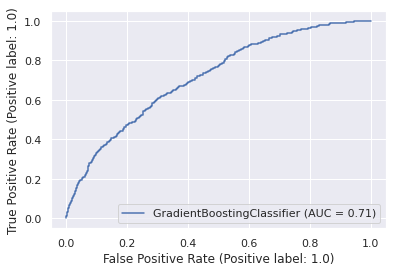

In [93]:
GradBoost = GradientBoostingClassifier(n_estimators=100, random_state=66)
GradBoost.fit(X_train, y_train)
y_pred3 = GradBoost.predict(X_test)
print("Accuracy with Gradient Boosting :", accuracy_score(y_test, y_pred3))
plot_roc_curve(GradBoost, X_test, y_test)

Accuracy on LGBM Classifier= 0.827020202020202


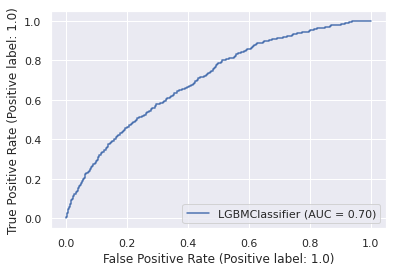

In [94]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred4 = lgbm.predict(X_test)
print("Accuracy on LGBM Classifier=", accuracy_score(y_test, y_pred4))
plot_roc_curve(lgbm, X_test, y_test)

LGBM_GetLastError().decode('utf-8') - попробуй декодировать по всем столбцам и выявить плохой - и переименовать - почему то не работает

Accuracy on CatBoost Classifier= 0.8279671717171717
AUC ROC on CatBoost Classifier:


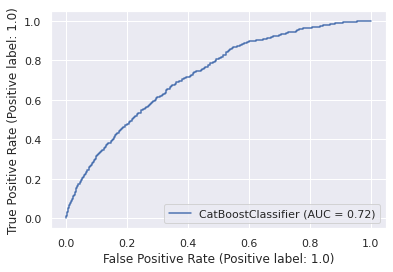

In [95]:
catBoost = CatBoostClassifier()
catBoost.fit(X_train,y_train,verbose=False)#, plot=True)
y_pred5 = catBoost.predict(X_test)
print("Accuracy on CatBoost Classifier=", accuracy_score(y_test, y_pred5))
print("AUC ROC on CatBoost Classifier:") 
plot_roc_curve(catBoost, X_test, y_test)
#catBoost.score(X_test, y_test)
# тут походу можно просто запихать df изначальный и все скушает

In [ ]:
"""
# небольшой эксперимент с catboost'ом : попробую запихать туда необработанный датасет
model_params = {
    'iterations': 500, 
    'loss_function': 'Logloss', 
    'train_dir': 'crossentropy',
    'allow_writing_files': False,
    'random_seed': 66,
}

cat_clf = CatBoostClassifier(**model_params)

X_ = df1.drop("Isdefault", axis=1)
y_ = df1["Isdefault"]
y_ = y.iloc[:-2].astype(int)
X_ = X.iloc[:-2, :]

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, train_size=0.8, random_state=66)
cat_clf.fit(X_train_, y_train_)
y_pred_ = cat_clf.predict(X_test_)
print("Accuracy score on raw data with CatBoost Classifier:", accuracy_score(y_test_, y_pred_))
print("Как видно, точность всё таки ниже, чем на обработанных данных => мы сделали предобработку данных неплохо")
"""

NameError: ignored

Accuracy on XGBoost Classifier = 0.8273358585858586
ROC AUC on XGBoost Classifier =


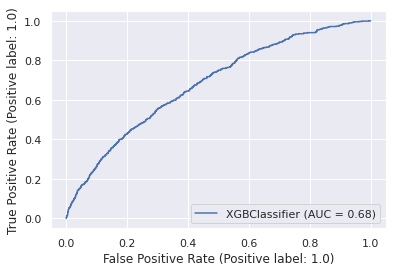

In [96]:
xg_cl = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_cl.fit(X_train,y_train)

y_pred6 = xg_cl.predict(X_test)
print("Accuracy on XGBoost Classifier =", accuracy_score(y_test, y_pred6))
print("ROC AUC on XGBoost Classifier =")
plot_roc_curve(xg_cl, X_test, y_test)

Accuracy on RandomForest Classifier = 0.8276515151515151
AUC ROC on RandomForest Classifier =


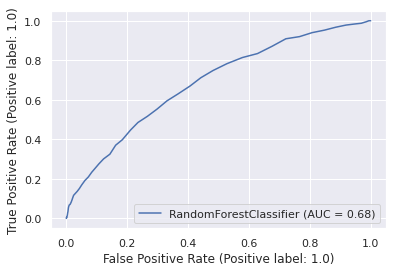

In [98]:
rf_cl = RandomForestClassifier()
rf_cl.fit(X_train,y_train)

y_pred7 = rf_cl.predict(X_test)
print("Accuracy on RandomForest Classifier =", accuracy_score(y_test, y_pred7))
print("AUC ROC on RandomForest Classifier =")
plot_roc_curve(rf_cl, X_test, y_test)

# Абстрагирование от данного датасета

In [ ]:
data = pd.read_csv('UCI_Credit_Card.csv')
data.head()

In [ ]:
data.drop(columns=['ID'], inplace=True)

In [ ]:
data.head()

In [ ]:
# хреновый датасет, оч мало признаков

In [ ]:
df = pd.read_csv("train_v2.csv")
df.head()